In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

## Simulation

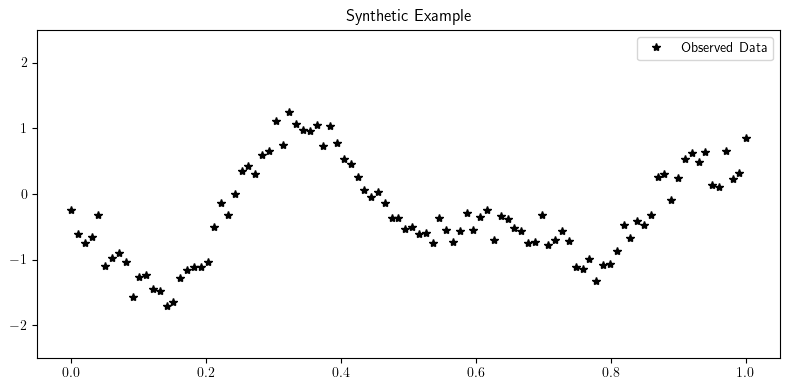

In [2]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
noise_variance = 0.04

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.linspace(0, 1, 100).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
K_train_noise = K_train + noise_variance * np.eye(len(x_train))
y_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train_noise).reshape(-1, 1)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(x_train, y_train, 'k*', label='Observed Data')
axs.set_title("Synthetic Example")
axs.set_ylim([-2.5, 2.5])
axs.legend()

plt.tight_layout()
plt.show()

## Standard GP

Optimized length_scale: 0.1021, noise: 0.033882, rbf_variance: 1.0000


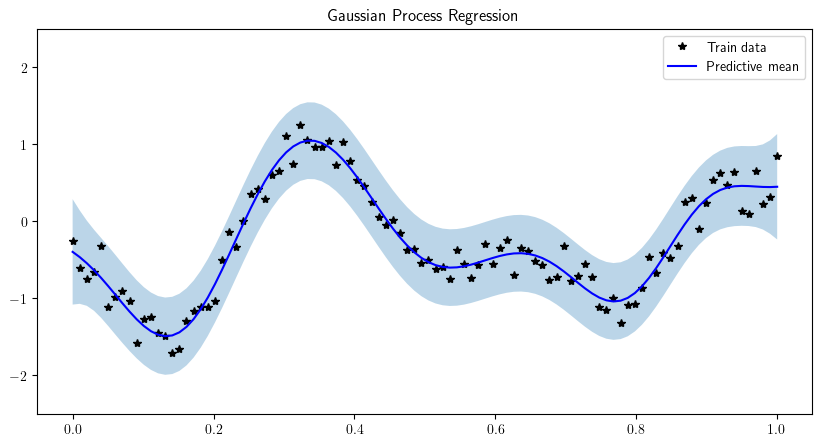

In [3]:
# Instantiate and train
gp = GPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04)
gp.fit(x_train, y_train)

# Optimize hyperparameters
gp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()

-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484
-58767.921666562484


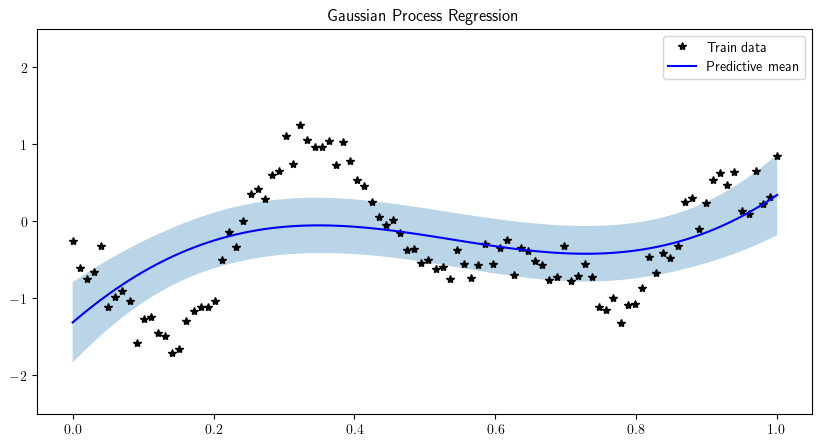

In [ ]:
# Instantiate and train
gp = GPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04)
gp.fit(x_train, y_train)

max_loss = -1e6

for ls in [0.01, 0.1, 1]:
    for rbf_v in [0.1, 1, 10]:
        for noise_l in [0.01, 0.04]:
            loss = gp.loo_cv(ls, rbf_v, noise_l)
            if loss > max_loss:
                max_loss = loss
            best_hp = ls, rbf_v, noise_l

best_ls, best_rbf_variance, best_noise = best_hp

gp = GPRegressor(mean=0, length_scale=best_ls, rbf_variance=best_rbf_variance, noise=best_noise)
gp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()

## RCGP

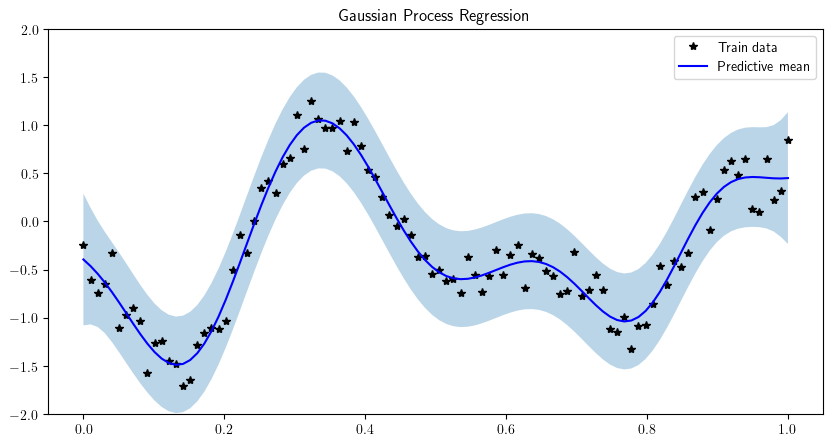

In [ ]:
# Instantiate and train
rcgp = RCGPRegressor(mean = 0, length_scale=0.1, rbf_variance = 1, noise = 0.04, epsilon = 0.01)
rcgp.fit(x_train, y_train)

# # Optimize hyperparameters
# rcgp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gp.predict(x_test)
std = np.sqrt(cov)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, 'k*', label='Train data')
plt.plot(x_test, mu.ravel(), 'b', label='Predictive mean')
plt.fill_between(x_test.ravel(), mu.ravel() - 2 * std, mu.ravel() + 2 * std, alpha=0.3)
plt.title("Gaussian Process Regression")
plt.ylim(-2, 2)
plt.legend()
plt.show()